In [2]:
#Import package yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
import tensorflow as tf
from keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2
from keras.layers import Bidirectional
from tensorflow.keras import layers
from keras.layers import Flatten

Upload File yang akan digunakan

In [1]:
from google.colab import files
uploaded=files.upload()

Saving curah hujan perhari.csv to curah hujan perhari.csv


In [4]:
df = pd.read_csv('curah hujan perhari.csv', sep=';')
dataSize = len(df)
df.tail()

,tanggal,curah hujan
1972,27/05/2023,0.0
1973,28/05/2023,2.3
1974,29/05/2023,2.5
1975,30/05/2023,12.0
1976,31/05/2023,0.0


Cek data hilang

In [5]:
df.isnull().sum()

tanggal         0
curah hujan    93
dtype: int64

Plot Data dengan Data Hilang

Text(0, 0.5, 'Jumlah')

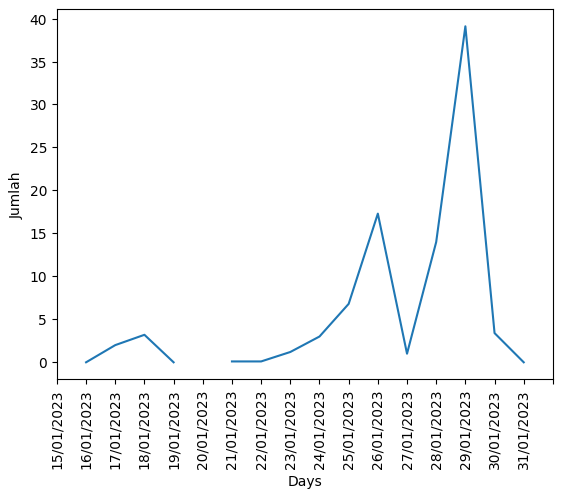

In [6]:
linspace = [0]
while linspace[-1] < 17-1:
    linspace.append(linspace[-1]+1)
linspace.append(17)

plt.plot(df['tanggal'][1840:1857], df['curah hujan'][1840:1857])
plt.xticks(linspace, rotation='vertical')
plt.xlabel('Days')
plt.ylabel('Jumlah')

Proses Imputasi

In [7]:
df['curah hujan'] = df['curah hujan'].interpolate(option='spline')

In [8]:
#Statistika Deskriptif
df.describe()

,curah hujan
count,1977.000000
mean,9.075063
std,15.995090
min,0.000000
25%,0.000000
50%,1.700000
75%,11.700000
max,164.100000


Plot Data Setelah Proses Imputasi

Text(0, 0.5, 'Jumlah')

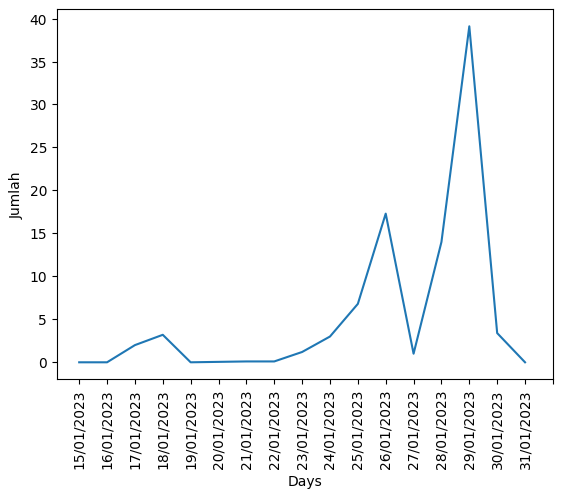

In [ ]:
linspace = [0]
while linspace[-1] < 17-1:
    linspace.append(linspace[-1]+1)
linspace.append(17)

plt.plot(df['tanggal'][1840:1857], df['curah hujan'][1840:1857])
plt.xticks(linspace, rotation='vertical')
plt.xlabel('Days')
plt.ylabel('Jumlah')

Plot Data Curah Hujan Harian Kabupaten Bogor

Text(0, 0.5, 'Jumlah')

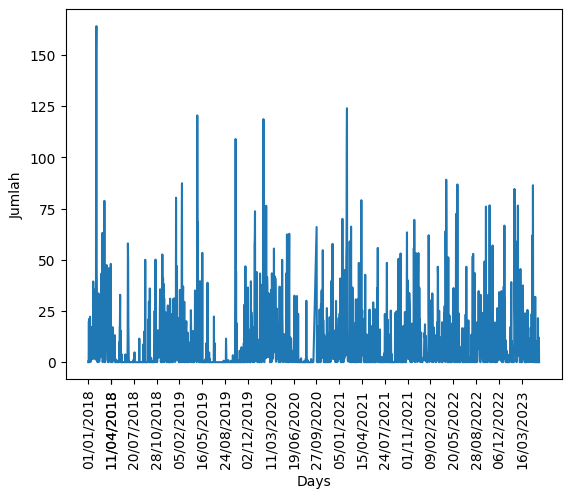

In [ ]:
linspace = [0]
while linspace[-1] < 1958-100:
    linspace.append(linspace[-1]+100)
linspace.append(100)

plt.plot(df['tanggal'], df['curah hujan'])
plt.xticks(linspace, rotation='vertical')
plt.xlabel('Days')
plt.ylabel('Jumlah')

In [ ]:
train_split = .8
train_size = int(train_split * dataSize)
trainData = df[:train_size]
valData = df[train_size:]
print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

Train data size:  (1581, 2)
Val data size:  (396, 2)


In [ ]:
trainData

,tanggal,curah hujan
0,01/01/2018,0.0
1,02/01/2018,0.6
2,03/01/2018,0.5
3,04/01/2018,20.0
4,05/01/2018,0.4
...,...,...
1576,26/04/2022,21.1
1577,27/04/2022,0.0
1578,28/04/2022,51.2
1579,29/04/2022,0.0


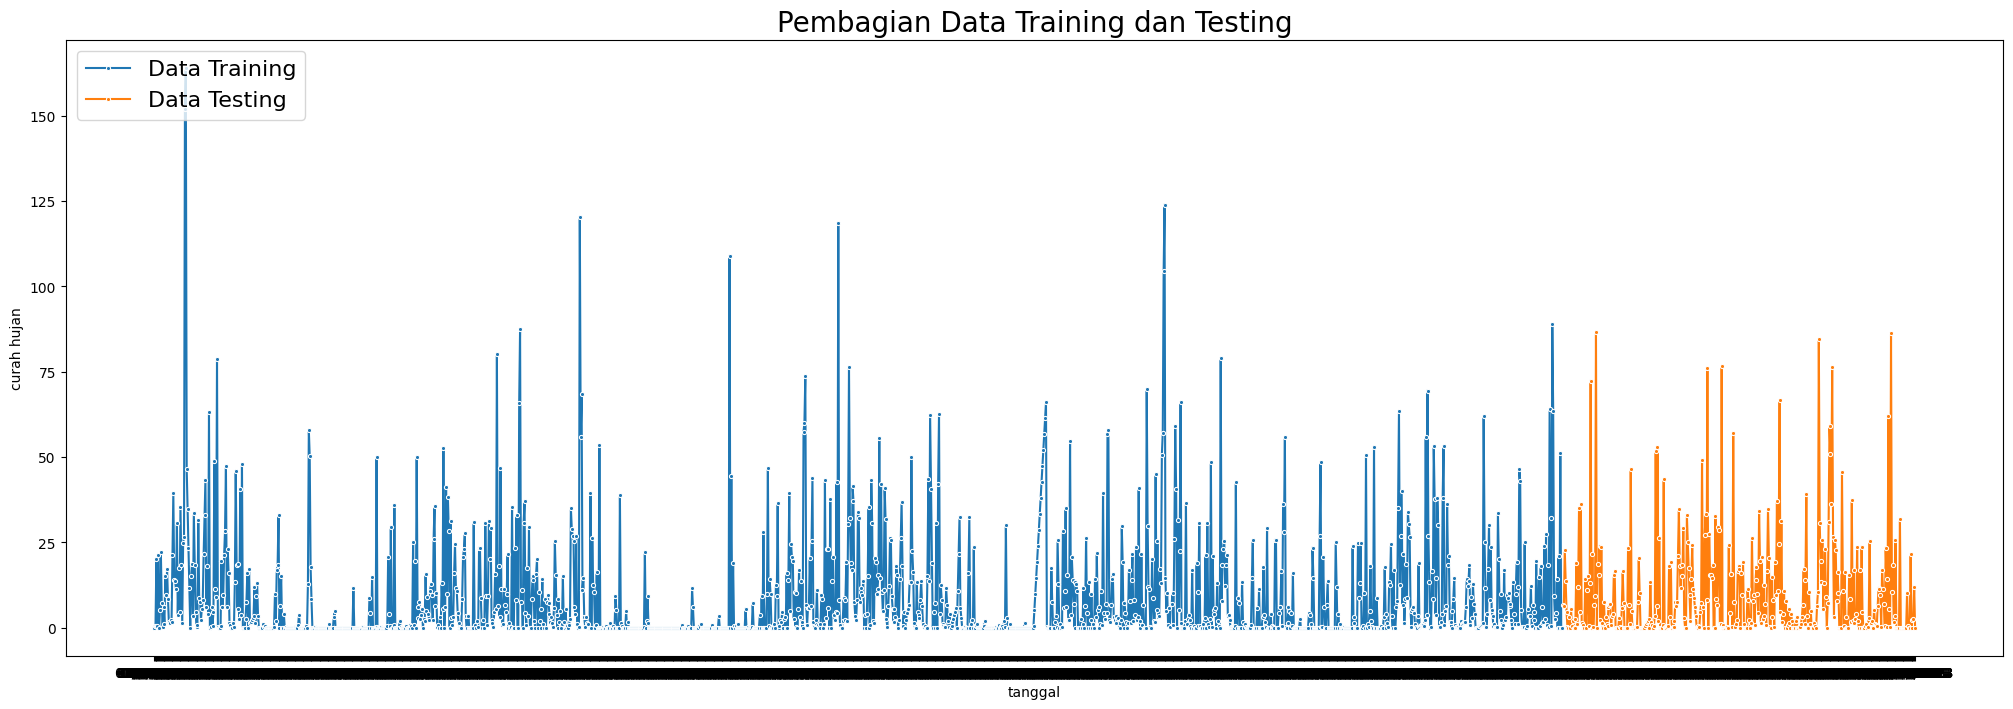

In [ ]:
plt.subplots(figsize = (25,8))
sns.lineplot(x="tanggal", y="curah hujan",
             data=trainData, marker='.', label='Data Training')
sns.lineplot(x="tanggal", y="curah hujan",
             data=valData, marker='.', label='Data Testing')
plt.title("Pembagian Data Training dan Testing", fontsize = 20)
plt.legend(loc='upper left', prop={'size': 16})

In [ ]:
dataMat = df['curah hujan'].values.reshape(dataSize,1)
dataMat.shape

(286, 1)

In [ ]:
#Scalling data menjadi nilai antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0,1))
scaledDataMat = scaler.fit_transform(dataMat)

In [ ]:
#Perbandingan nilai asli dengan nilai hasil scaling
df_scaled = pd.DataFrame(columns=['tanggal', 'Curah hujan', 'Curah hujan Normal'])
df_scaled['tanggal'] = df['tanggal']
df_scaled['Curah hujan'] = df['curah hujan']
df_scaled['Curah hujan Normal'] = scaledDataMat
df_scaled

,tanggal,Curah hujan,Curah hujan Normal
0,01/01/2018,0.0,0.000000
1,02/01/2018,0.6,0.003656
2,03/01/2018,0.5,0.003047
3,04/01/2018,20.0,0.121877
4,05/01/2018,0.4,0.002438
...,...,...,...
1972,27/05/2023,0.0,0.000000
1973,28/05/2023,2.3,0.014016
1974,29/05/2023,2.5,0.015235
1975,30/05/2023,12.0,0.073126


In [ ]:
#Pembagian datatrain dan test
train_split = .8
train_size = int(train_split * dataSize)
trainData = scaledDataMat[:train_size]
valData = scaledDataMat[train_size:]
print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

Train data size:  (228, 1)
Val data size:  (58, 1)


In [ ]:
def createDataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		dataX.append(dataset[i:(i+time_step)])
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [ ]:
n_past = 7 # h = 7, 14, dan 28 forecast ahead (input1) #
X_train,y_train = createDataset(trainData, time_step=n_past)
X_val,y_val = createDataset(valData, time_step=n_past)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(216, 12, 1) (216, 1)
(46, 12, 1) (46, 1)


In [ ]:
tf.random.set_seed(1234)

In [ ]:
from keras.layers import GRU
from keras.layers import Bidirectional
from tensorflow.keras import layers
from keras.layers import Flatten

MODEL VANILLA GRU

In [ ]:
#Model GRU
tf.keras.backend.clear_session()
model_GRU = Sequential()
model_GRU.add(GRU(256,activation='relu',kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),return_sequences=False, input_shape=X_train[0].shape)) # activation = relu ( input 3)#
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_GRU.compile(loss='mape',optimizer='adam')  # opt=adm (input 4)#
history_GRU = model_GRU.fit(X_train,y_train,validation_data=(X_val,y_val), batch_size=4, epochs=1000, callbacks=[callback]) # batch_size, Input =5 #

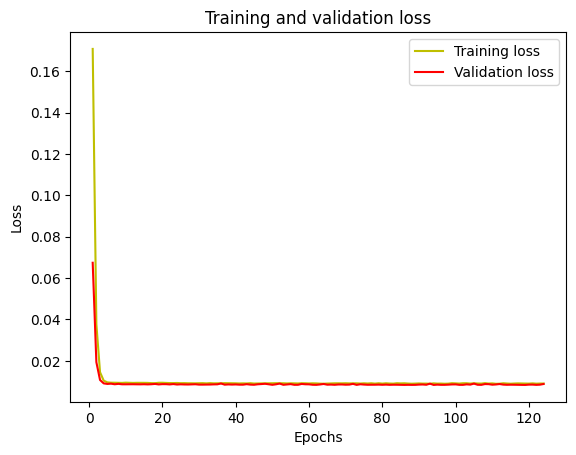

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_GRU.evaluate(X_train,y_train)

56/56 [==============================] - 0s 2ms/step - loss: 0.0089


0.008868036791682243

In [ ]:
#Evaluasi model
model_GRU.evaluate(X_val,y_val)

6/6 [==============================] - 0s 3ms/step - loss: 0.0084


0.00836009532213211

In [ ]:
y_train_hat = scaler.inverse_transform(model_GRU.predict(X_train))
y_val_hat = scaler.inverse_transform(model_GRU.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

6/6 [==============================] - 0s 5ms/step


Text(0, 0.5, 'Curah Hujan')

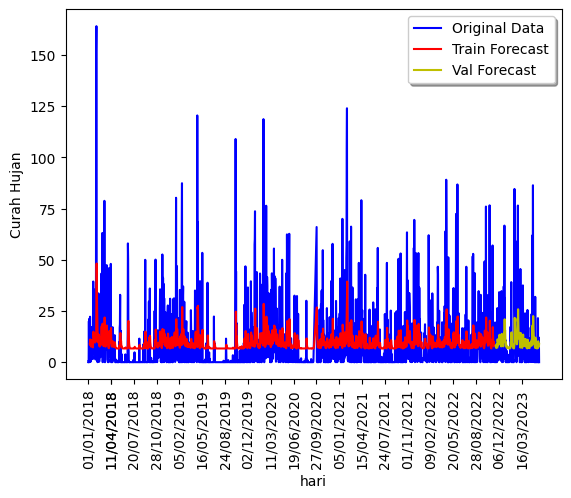

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_GRU_train = mean_squared_error(ytrain, y_train_hat)
rmse_GRU_train=np.sqrt(mse_GRU_train)
print('Nilai RMSE train: %.3f' % rmse_GRU_train)
mse_GRU_test = mean_squared_error(yval, y_val_hat)
rmse_GRU_test=np.sqrt(mse_GRU_test)
print('Nilai RMSE test: %.3f' % rmse_GRU_test)

Nilai RMSE train: 15.312
Nilai RMSE test: 14.859


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_GRU_train = mean_absolute_error(ytrain,y_train_hat)
mae_GRU_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_GRU_train)
print('Nilai MAE test: %.3f' % mae_GRU_test)

Nilai MAE train: 10.275
Nilai MAE test: 9.952


In [ ]:
# generate the multi-step forecasts
def forecasts(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_GRU.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

In [ ]:
GRU_forecast=forecasts(n_past=0, n_future=14)

1/1 [==============================] - 0s 23ms/step


In [ ]:
GRU_forecast

array([9.003423 , 9.246869 , 9.408665 , 9.516224 , 9.587443 , 9.634852 ,
       9.6664915, 9.686865 , 9.700989 , 9.710425 , 9.715795 , 9.720157 ,
       9.72297  , 9.725012 ], dtype=float32)

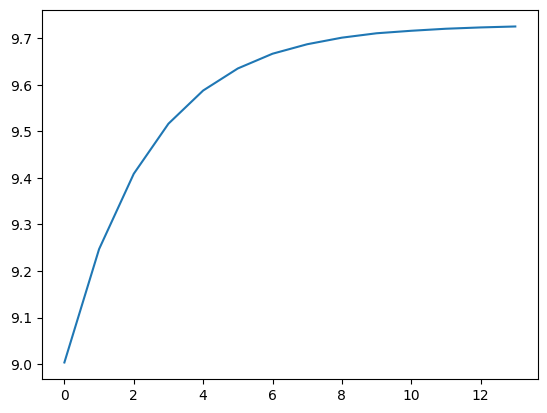

In [ ]:
plt.plot(GRU_forecast)

MODEL STACKED GRU

In [ ]:
##model Stacked GRU
tf.keras.backend.clear_session()
model_SGRU = Sequential()
model_SGRU.add(GRU(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', return_sequences=True, input_shape=X_train[0].shape))
model_SGRU.add(GRU(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu',return_sequences=False))
model_SGRU.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_SGRU.compile(loss='mae',optimizer='adam')
history_SGRU = model_SGRU.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=16,epochs=500, callbacks=[callback])

Epoch 1/500
97/97 [==============================] - 7s 39ms/step - loss: 0.6453 - val_loss: 0.3101
Epoch 2/500
97/97 [==============================] - 4s 42ms/step - loss: 0.1801 - val_loss: 0.1124
Epoch 3/500
97/97 [==============================] - 3s 36ms/step - loss: 0.0788 - val_loss: 0.0732
Epoch 4/500
97/97 [==============================] - 3s 32ms/step - loss: 0.0581 - val_loss: 0.0632
Epoch 5/500
97/97 [==============================] - 3s 33ms/step - loss: 0.0543 - val_loss: 0.0616
Epoch 6/500
97/97 [==============================] - 4s 44ms/step - loss: 0.0532 - val_loss: 0.0608
Epoch 7/500
97/97 [==============================] - 3s 32ms/step - loss: 0.0529 - val_loss: 0.0608
Epoch 8/500
97/97 [==============================] - 3s 33ms/step - loss: 0.0531 - val_loss: 0.0616
Epoch 9/500
97/97 [==============================] - 3s 31ms/step - loss: 0.0529 - val_loss: 0.0622
Epoch 10/500
97/97 [==============================] - 4s 42ms/step - loss: 0.0528 - val_loss: 0.0625

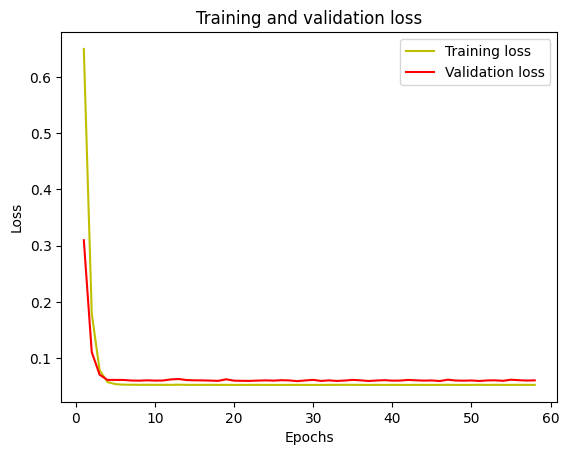

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_SGRU.history['loss']
val_loss = history_SGRU.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_SGRU.evaluate(X_train,y_train)

49/49 [==============================] - 0s 8ms/step - loss: 0.0533


0.05330653488636017

In [ ]:
#Evaluasi model
model_SGRU.evaluate(X_val,y_val)

12/12 [==============================] - 0s 9ms/step - loss: 0.0608


0.06077089160680771

In [ ]:
y_train_hat = scaler.inverse_transform(model_SGRU.predict(X_train))
y_val_hat = scaler.inverse_transform(model_SGRU.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

12/12 [==============================] - 0s 8ms/step


Text(0, 0.5, 'Curah Hujan')

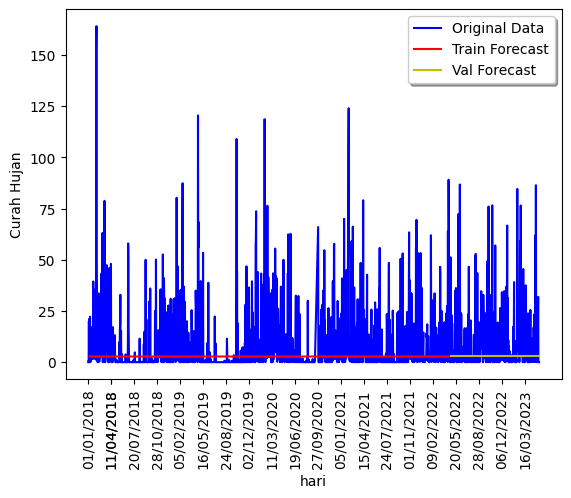

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_SGRU_train = mean_squared_error(ytrain, y_train_hat)
rmse_SGRU_train=np.sqrt(mse_SGRU_train)
print('Nilai RMSE train: %.3f' % rmse_SGRU_train)
mse_SGRU_test = mean_squared_error(yval, y_val_hat)
rmse_SGRU_test=np.sqrt(mse_SGRU_test)
print('Nilai RMSE test: %.3f' % rmse_SGRU_test)

Nilai RMSE train: 16.317
Nilai RMSE test: 16.619


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_SGRU_train = mean_absolute_error(ytrain,y_train_hat)
mae_SGRU_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_SGRU_train)
print('Nilai MAE test: %.3f' % mae_SGRU_test)

Nilai MAE train: 8.720
Nilai MAE test: 9.945


In [ ]:
# generate the multi-step forecasts
def forecasts(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_SGRU.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

    SGRU_forecast=forecast(n_past=0,n_future=28)
    SGRU_forecast

In [ ]:
plt.plot(SGRU_forecast)

MODEL BIDIRECTIONAL GRU

In [ ]:
#model BiGRU
tf.keras.backend.clear_session()
model_biGRU = Sequential()
model_biGRU.add(Bidirectional(GRU(256,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', input_shape=X_train[0].shape)))
model_biGRU.add(Dropout(0.2))
model_biGRU.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_biGRU.compile(loss='mae',optimizer='adam')
history_biGRU = model_biGRU.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=16, epochs=200, callbacks=[callback])

Epoch 1/200
98/98 [==============================] - 11s 64ms/step - loss: 1.1864 - val_loss: 0.1091
Epoch 2/200
98/98 [==============================] - 4s 44ms/step - loss: 0.0626 - val_loss: 0.0596
Epoch 3/200
98/98 [==============================] - 5s 48ms/step - loss: 0.0516 - val_loss: 0.0608
Epoch 4/200
98/98 [==============================] - 5s 51ms/step - loss: 0.0511 - val_loss: 0.0589
Epoch 5/200
98/98 [==============================] - 5s 52ms/step - loss: 0.0509 - val_loss: 0.0589
Epoch 6/200
98/98 [==============================] - 5s 56ms/step - loss: 0.0512 - val_loss: 0.0592
Epoch 7/200
98/98 [==============================] - 4s 41ms/step - loss: 0.0509 - val_loss: 0.0589
Epoch 8/200
98/98 [==============================] - 4s 36ms/step - loss: 0.0510 - val_loss: 0.0598
Epoch 9/200
98/98 [==============================] - 5s 51ms/step - loss: 0.0507 - val_loss: 0.0594
Epoch 10/200
98/98 [==============================] - 4s 38ms/step - loss: 0.0512 - val_loss: 0.059

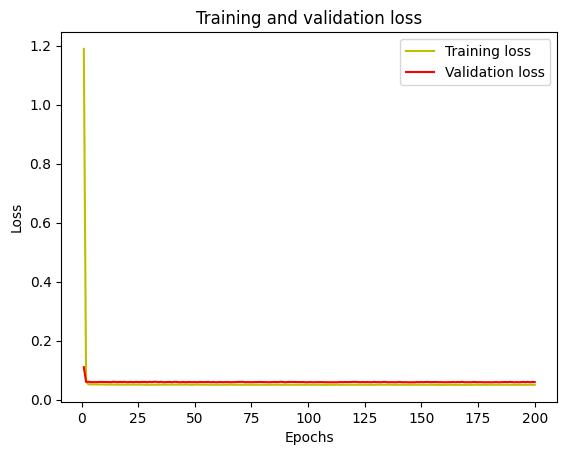

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_biGRU.history['loss']
val_loss = history_biGRU.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_train_hat = scaler.inverse_transform(model_biGRU.predict(X_train))
y_val_hat = scaler.inverse_transform(model_biGRU.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

13/13 [==============================] - 0s 17ms/step


Text(0, 0.5, 'Curah Hujan')

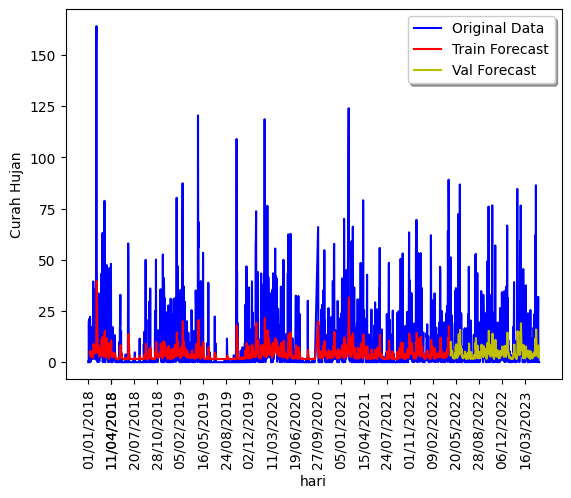

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
model_biGRU.evaluate(X_train,y_train)

49/49 [==============================] - 1s 11ms/step - loss: 0.0510


0.05095962435007095

In [ ]:
#Evaluasi model
model_biGRU.evaluate(X_val,y_val)

13/13 [==============================] - 0s 11ms/step - loss: 0.0586


0.0586329847574234

In [ ]:
from sklearn.metrics import mean_squared_error
mse_biGRU_train = mean_squared_error(ytrain, y_train_hat)
rmse_biGRU_train=np.sqrt(mse_biGRU_train)
print('Nilai RMSE train: %.3f' % rmse_biGRU_train)
mse_biGRU_test = mean_squared_error(yval, y_val_hat)
rmse_biGRU_test=np.sqrt(mse_biGRU_test)
print('Nilai RMSE test: %.3f' % rmse_biGRU_test)

Nilai RMSE train: 16.237
Nilai RMSE test: 16.677


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_biGRU_train = mean_absolute_error(ytrain,y_train_hat)
mae_biGRU_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_biGRU_train)
print('Nilai MAE test: %.3f' % mae_biGRU_test)

Nilai MAE train: 8.164
Nilai MAE test: 9.671


In [ ]:
# generate the multi-step forecasts
def forecast(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_biGRU.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

biGRU_forecast=forecast(n_past=0,n_future=7)
biGRU_forecast

1/1 [==============================] - 0s 30ms/step


array([1.9657514, 2.0140855, 2.0284255, 2.0120065, 2.048039 , 2.0714538,
       2.0868707], dtype=float32)

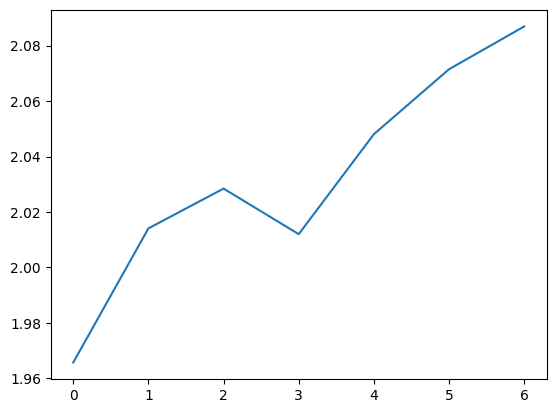

In [ ]:
plt.plot(biGRU_forecast)

MODEL STACKED BIDIRECTIONAL GRU

In [ ]:
#model Stacked BiGRU
tf.keras.backend.clear_session()
model_SbiGRU = Sequential()
model_SbiGRU.add(Bidirectional(GRU(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', return_sequences=True, input_shape=X_train[0].shape)))
model_SbiGRU.add(Dropout(0.2))
model_SbiGRU.add(Bidirectional(GRU(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             return_sequences=False,activation='relu')))
model_SbiGRU.add(Dropout(0.2))
model_SbiGRU.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_SbiGRU.compile(loss='mae',optimizer='adam')
history_SbiGRU = model_SbiGRU.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=16, epochs=500, callbacks=[callback])

Epoch 1/500
97/97 [==============================] - 18s 77ms/step - loss: 1.4833 - val_loss: 0.6163
Epoch 2/500
97/97 [==============================] - 8s 78ms/step - loss: 0.3220 - val_loss: 0.1599
Epoch 3/500
97/97 [==============================] - 6s 62ms/step - loss: 0.1005 - val_loss: 0.0805
Epoch 4/500
97/97 [==============================] - 7s 76ms/step - loss: 0.0618 - val_loss: 0.0663
Epoch 5/500
97/97 [==============================] - 6s 63ms/step - loss: 0.0550 - val_loss: 0.0637
Epoch 6/500
97/97 [==============================] - 7s 75ms/step - loss: 0.0531 - val_loss: 0.0610
Epoch 7/500
97/97 [==============================] - 6s 63ms/step - loss: 0.0530 - val_loss: 0.0618
Epoch 8/500
97/97 [==============================] - 7s 75ms/step - loss: 0.0528 - val_loss: 0.0621
Epoch 9/500
97/97 [==============================] - 6s 61ms/step - loss: 0.0527 - val_loss: 0.0620
Epoch 10/500
97/97 [==============================] - 7s 76ms/step - loss: 0.0528 - val_loss: 0.061

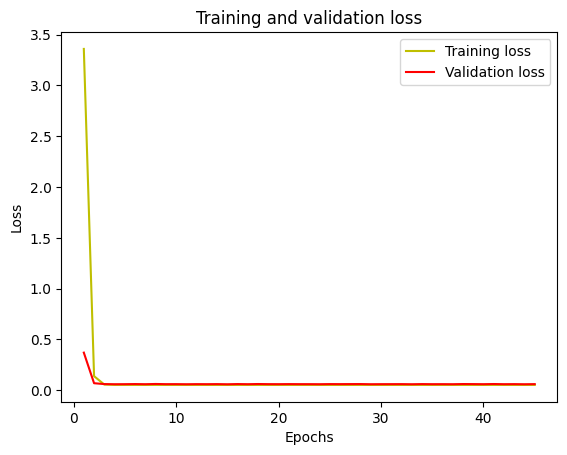

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_SbiGRU.history['loss']
val_loss = history_SbiGRU.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_SbiGRU.evaluate(X_train,y_train)

49/49 [==============================] - 1s 17ms/step - loss: 0.0534


0.05336037650704384

In [ ]:
#Evaluasi model
model_SbiGRU.evaluate(X_val,y_val)

12/12 [==============================] - 0s 15ms/step - loss: 0.0610


0.06095445528626442

In [ ]:
y_train_hat = scaler.inverse_transform(model_SbiGRU.predict(X_train))
y_val_hat = scaler.inverse_transform(model_SbiGRU.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

12/12 [==============================] - 0s 22ms/step


Text(0, 0.5, 'Curah Hujan')

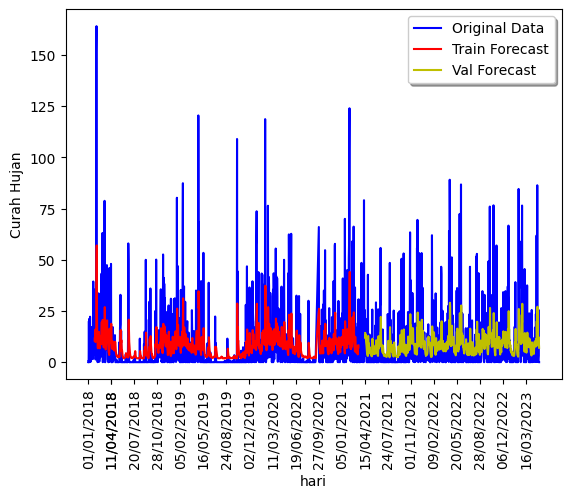

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_SbiGRU_train = mean_squared_error(ytrain, y_train_hat)
rmse_SbiGRU_train=np.sqrt(mse_SbiGRU_train)
print('Nilai RMSE train: %.3f' % rmse_SbiGRU_train)
mse_SbiGRU_test = mean_squared_error(yval, y_val_hat)
rmse_SbiGRU_test=np.sqrt(mse_SbiGRU_test)
print('Nilai RMSE test: %.3f' % rmse_SbiGRU_test)

Nilai RMSE train: 17.977
Nilai RMSE test: 16.579


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_SbiGRU_train = mean_absolute_error(ytrain,y_train_hat)
mae_SbiGRU_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_SbiGRU_train)
print('Nilai MAE test: %.3f' % mae_SbiGRU_test)

Nilai MAE train: 8.722
Nilai MAE test: 9.968


In [ ]:
# generate the multi-step forecasts
def forecast(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_SbiGRU.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

SbiGRU_forecast=forecast(n_past=0,n_future=7)
SbiGRU_forecast

1/1 [==============================] - 0s 42ms/step


array([ 9.275712, 10.503481, 10.980982, 11.457291, 11.730136, 11.653479,
       11.711149], dtype=float32)

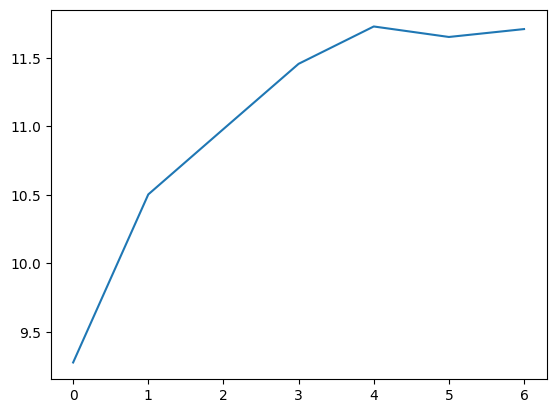

In [ ]:
plt.plot(SbiGRU_forecast)

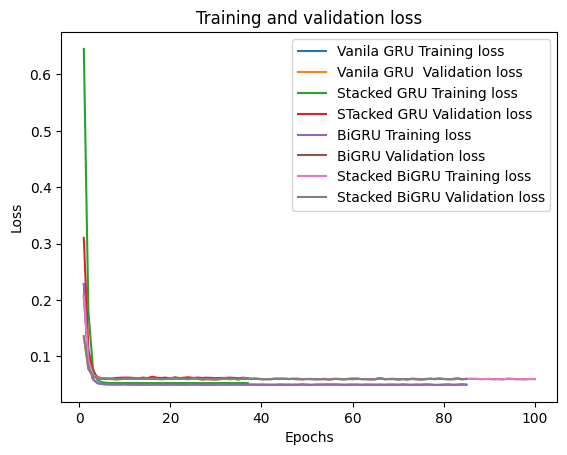

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss_vanila = history_GRU.history['loss']
val_loss_vanila = history_GRU.history['val_loss']
loss_stacked = history_SGRU.history['loss']
val_loss_stacked = history_SGRU.history['val_loss']
loss_biGRU = history_GRU.history['loss']
val_loss_biGRU =history_biGRU.history['val_loss']
loss_stacked_biGRU = history_biGRU.history['val_loss']
val_loss_stacked_biGRU = history_GRU.history['val_loss']
epochs_loss_vanila = range(1, len(loss_vanila) + 1)
epochs_loss_stacked = range(1, len(loss_stacked) + 1)
epochs_loss_biGRU = range(1, len(loss_biGRU) + 1)
epochs_loss_stacked_biGRU = range(1, len(loss_stacked_biGRU) + 1)
epochs_val_loss_vanila = range(1, len(val_loss_vanila) + 1)
epochs_val_loss_stacked = range(1, len(val_loss_stacked) + 1)
epochs_val_loss_biGRU = range(1, len(val_loss_biGRU) + 1)
epochs_val_loss_stacked_biGRU = range(1, len(val_loss_stacked_biGRU) + 1)
plt.plot(epochs_loss_vanila, loss_vanila, label='Vanila GRU Training loss')
plt.plot(epochs_val_loss_vanila, val_loss_vanila, label='Vanila GRU  Validation loss')
plt.plot(epochs_loss_stacked, loss_stacked, label='Stacked GRU Training loss')
plt.plot(epochs_val_loss_stacked, val_loss_stacked, label='STacked GRU Validation loss')
plt.plot(epochs_loss_biGRU, loss_biGRU, label='BiGRU Training loss')
plt.plot(epochs_val_loss_biGRU, val_loss_biGRU, label='BiGRU Validation loss')
plt.plot(epochs_loss_stacked_biGRU, loss_stacked_biGRU, label='Stacked BiGRU Training loss')
plt.plot(epochs_val_loss_stacked_biGRU, val_loss_stacked_biGRU, label='Stacked BiGRU Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NYOBA GRID SEARCH DARI GITUHUB INI LINKNYA https://github.com/akmuthun/Time-Series-Neural-Network-Grid-Search/blob/master/Multi%20Step%20Forecasting-MLP%20NN-Grid%20Search.ipynb

In [ ]:
#from math import sqrt
#from numpy import array
#from numpy import mean
#from pandas import DataFrame
#from pandas import concat
#from pandas import read_csv
#from sklearn.metrics import mean_squared_error


In [ ]:
#read time series dataset assume only one column = "univariate"
#dataset = scaledDataMat

In [ ]:
# split a univariate dataset into train/test sets
#def train_test_split(data, n_test):
#	return data[:-n_test], data[-n_test:]
# n_in = n_input = width of the sliding window which the number of input time steps in one row
# of the training data. We can decide the value of "n_input"
# in the main code when we specify configurations.


In [ ]:
# transform list into supervised learning format
#def series_to_supervised(data, n_in, n_out=1):
#	df = DataFrame(data)
#	cols = list()
	# input sequence (t-n, ... t-1)
#	for i in range(n_in, 0, -1):
#		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
#	for i in range(0, n_out):
#		cols.append(df.shift(-i))
	# put it all together
#	agg = concat(cols, axis=1)
	# drop rows with NaN values
#	agg.dropna(inplace=True)
#	return agg.values


In [ ]:
# root mean squared error or rmse
#def measure_rmse(actual, predicted):
#	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
#def difference(data, order):
#	return [data[i] - data[i - order] for i in range(order, len(data))]


In [ ]:
# fit a model
#def model_fit(train, config, num_step):
	# unpack config
#	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
#	if n_diff > 0:
#		train = difference(train, n_diff)
	# transform series into supervised format
#	data = series_to_supervised(train, n_in=n_input, n_out=num_step)#####################
	# separate inputs and outputs
#	train_x, train_y = data[:, :-num_step], data[:, -num_step:] ################
	# reshape input data into [samples, timesteps, features]
#	n_features = 1 #if it is multivariate then this should be changed acccordingly
#	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
#	model = tf.keras.Sequential([
#	tf.keras.layers.GRU(n_nodes, activation='relu',recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=(n_input, n_features)),
#	tf.keras.layers.Dense(num_step)])###############
#	model.compile(loss='mse', optimizer='adam')
	# fit model
#	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
#	return model

In [ ]:
# forecast with the fit model
#def model_predict(model, history, config):
	# unpack config
#	n_input, _, _, _, n_diff = config
	# prepare data
#	correction = 0.0
#	if n_diff > 0:
#		correction = history[-n_diff]
#		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
#	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
#	yhat = model.predict(x_input, verbose=0)
#	return correction + yhat[0]

In [ ]:
# walk-forward validation for univariate data
#def walk_forward_validation(data, n_test, cfg, num_step):###########
#	error_collection=list()################
	# split dataset
#	train, test = train_test_split(data, n_test)
	# fit model
#	model = model_fit(train, cfg, num_step)##############
	# seed history with training dataset
#	history = [x for x in train]
	# step over each time-step in the test set
#	for i in range(len(test)+1-num_step):############
		# fit model and make forecast for history
#		yhat = model_predict(model, history, cfg)
#		err = measure_rmse(test[i:i+num_step], yhat)#############
#		error_collection.append(err)
		# store forecast in list of predictions
		# add actual observation to history for the next loop
#		history.append(test[i])
	# estimate prediction error
#	error = mean(error_collection)######
	#print(' > %.3f' % error)
#	return error

In [ ]:
# score a model, return None on failure
#def repeat_evaluate(data, config, n_test, num_step, n_repeats=5):############
	# convert config to a key
#	key = str(config)
	# fit and evaluate the model n times
#	scores = [walk_forward_validation(data, n_test, config, num_step) for _ in range(n_repeats)]##########
	# summarize score
#	result = mean(scores)

#	return (result, config)#######


In [ ]:
# grid search configs
#def grid_search(data, cfg_list, n_test, num_step):#########
	# evaluate configs
#	scores = [repeat_evaluate(data, cfg, n_test, num_step) for cfg in cfg_list]#########
	# sort configs by error, asc
#	scores.sort()##########
#	return scores

In [ ]:
## create a list of configs to try
#def model_configs():
	# define scope of configs
#	n_input = [14]
#	n_nodes = [5,6,7,8,9,10,16,64,64,128]
#	n_epochs = [100]
#	n_batch = [16,32,64]
#	n_diff = [0]
	# create configs
#	configs = list()
#	for i in n_input:
#		for j in n_nodes:
#			for k in n_epochs:
#				for l in n_batch:
#					for m in n_diff:
#						cfg = [i, j, k, l, m]
#						configs.append(cfg)
#	print('Total configs: %d' % len(configs))
#	return configs

In [ ]:
#location_counter = 0
#n_test = 5 # keep this fixed
#data = dataset
#step_list = []
#location_list = []
#cfg_list = []
#error_list = []
#window_length_list = []
#nodes_list = []
#epochs_list = []
#batch_size_list = []
#diff_list =[]

#for num in [3]:# number of steps to forecast, this can be any number between 1 and 5
#  num_step = num
#  cfg_list = model_configs()
#  scores = grid_search(data, cfg_list, n_test, num_step)
#  print('done for the step: %d' % num_step)
  # list top 3 configs
#  error, cfg = scores[0]
#  print(cfg, error)
#  window_length_list.append(cfg[0])
#  nodes_list.append(cfg[1])
#  epochs_list.append(cfg[2])
#  batch_size_list.append(cfg[3])
#  diff_list.append(cfg[4])
#  error_list.append(error)
#  step_list.append(num_step)


In [ ]:
#collection = DataFrame()
#collection['Predict Step'] = step_list
#collection['Error'] = error_list
#collection['window width'] = window_length_list
#collection['Nodes'] = nodes_list
#collection['Epochs'] = epochs_list
#collection['batch size'] = batch_size_list
#collection['difference'] = diff_list
#collection.to_csv('TS.csv')